# Подключаем библиотеки

In [78]:
import os

import torchvision.datasets
import torchvision.transforms

import torch.nn

import matplotlib.pyplot as plt

import time

# Загружаем данные

In [50]:
dir_name = os.getcwd()
train_dataset = torchvision.datasets.CIFAR10(
    root = dir_name, train = True, download = True,
    transform = torchvision.transforms.ToTensor()
)
test_dataset = torchvision.datasets.CIFAR10(
    root = dir_name, train = False, download = True,
    transform = torchvision.transforms.ToTensor()
)

Files already downloaded and verified
Files already downloaded and verified


## Примеры изображений

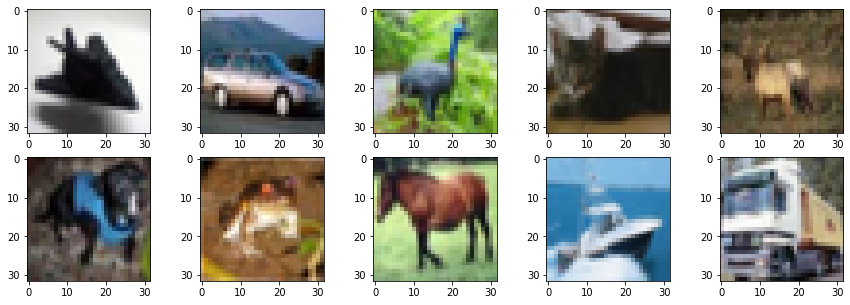

In [76]:
fig, axes = plt.subplots(2, 5, figsize = (15, 5))
for label in range(10):
  for i in range(len(train_dataset)):
    if label == train_dataset[i][1]:
      axes[label // 5, label % 5].imshow(train_dataset[i][0].permute(1, 2, 0))
      break
plt.show()

In [51]:
train_data_loader = torch.utils.data.DataLoader(
    train_dataset, batch_size = 50, shuffle = True
)
test_data_loader = torch.utils.data.DataLoader(
    test_dataset, batch_size = 50, shuffle = False
)

In [52]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

def get_accuracy(data_loader, model):
    tp = 0
    n = 0
    with torch.no_grad():
        for images, labels in data_loader:
            labels = labels.to(device)
            images = images.to(device)
            outputs = model(images)
            _, predicted = torch.max(outputs.data, 1)
            n += labels.size(0)
            tp += (predicted == labels).sum()
    return tp / n

# resnet50

In [53]:
torchvision.models.resnet50()

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 

## Полностью обучаем модель

In [54]:
model_resnet50 = torch.nn.Sequential(
    torchvision.models.resnet50(weights = torchvision.models.ResNet50_Weights.DEFAULT),
    torch.nn.Linear(1000, 10)).to(device)

learning_rate = 0.1
num_epochs = 30

loss_function = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model_resnet50.parameters(), lr = learning_rate)

total_time_resnet50 = 0

for epoch in range(num_epochs):
    start = time.time()
    for i, (images, labels) in enumerate(train_data_loader):
        images = images.to(device)
        labels = labels.to(device)

        outputs = model_resnet50(images)
        loss = loss_function(outputs, labels)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
    epoch_time = time.time() - start
    total_time_resnet50 += epoch_time

    print(f'Epoch {epoch}')
    print(f'    accuracy on train data : {get_accuracy(train_data_loader, model_resnet50)}')
    print(f'    epoch_time = {int(epoch_time // 60)} min, {int(epoch_time % 60)} sec')

Downloading: "https://download.pytorch.org/models/resnet50-11ad3fa6.pth" to /tmp/xdg_cache/torch/hub/checkpoints/resnet50-11ad3fa6.pth
100%|██████████| 97.8M/97.8M [00:01<00:00, 56.0MB/s]


Epoch 0
    accuracy on train data : 0.7996000051498413
    epoch_time = 3 min, 19 sec
Epoch 1
    accuracy on train data : 0.8412200212478638
    epoch_time = 3 min, 18 sec
Epoch 2
    accuracy on train data : 0.8812999725341797
    epoch_time = 3 min, 18 sec
Epoch 3
    accuracy on train data : 0.9038199782371521
    epoch_time = 3 min, 15 sec
Epoch 4
    accuracy on train data : 0.9329000115394592
    epoch_time = 3 min, 18 sec
Epoch 5
    accuracy on train data : 0.9419999718666077
    epoch_time = 3 min, 16 sec
Epoch 6
    accuracy on train data : 0.9630200266838074
    epoch_time = 3 min, 15 sec
Epoch 7
    accuracy on train data : 0.9610999822616577
    epoch_time = 3 min, 17 sec
Epoch 8
    accuracy on train data : 0.9685800075531006
    epoch_time = 3 min, 16 sec
Epoch 9
    accuracy on train data : 0.968559980392456
    epoch_time = 3 min, 14 sec
Epoch 10
    accuracy on train data : 0.9757000207901001
    epoch_time = 3 min, 13 sec
Epoch 11
    accuracy on train data : 0.980

## Обучаем последний слой

In [55]:
model_resnet50_fix = torchvision.models.resnet50(weights = torchvision.models.ResNet50_Weights.DEFAULT).to(device)

learning_rate = 0.1
num_epochs = 6

for param in model_resnet50_fix.parameters():
    param.requires_grad = False

model_resnet50_fix.fc = torch.nn.Linear(2048, 10).to(device)

loss_function = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model_resnet50_fix.fc.parameters(), lr = learning_rate)

total_time_resnet50_fix = 0

for epoch in range(num_epochs):
    start = time.time()
    for i, (images, labels) in enumerate(train_data_loader):
        images = images.to(device)
        labels = labels.to(device)

        outputs = model_resnet50_fix(images) 
        loss = loss_function(outputs, labels)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
    epoch_time = time.time() - start
    total_time_resnet50_fix += epoch_time

    print(f'Epoch {epoch}')
    print(f'    accuracy on train data : {get_accuracy(train_data_loader, model_resnet50_fix)}')
    print(f'    epoch_time = {int(epoch_time // 60)} min, {int(epoch_time % 60)} sec')

Epoch 0
    accuracy on train data : 0.4004800021648407
    epoch_time = 0 min, 59 sec
Epoch 1
    accuracy on train data : 0.4131599962711334
    epoch_time = 1 min, 0 sec
Epoch 2
    accuracy on train data : 0.40953999757766724
    epoch_time = 1 min, 1 sec
Epoch 3
    accuracy on train data : 0.4162600040435791
    epoch_time = 1 min, 2 sec
Epoch 4
    accuracy on train data : 0.4100399911403656
    epoch_time = 1 min, 1 sec
Epoch 5
    accuracy on train data : 0.4118399918079376
    epoch_time = 1 min, 0 sec


# efficientnet_v2_s

In [56]:
torchvision.models.efficientnet_v2_s()

EfficientNet(
  (features): Sequential(
    (0): Conv2dNormActivation(
      (0): Conv2d(3, 24, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
      (1): BatchNorm2d(24, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
      (2): SiLU(inplace=True)
    )
    (1): Sequential(
      (0): FusedMBConv(
        (block): Sequential(
          (0): Conv2dNormActivation(
            (0): Conv2d(24, 24, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
            (1): BatchNorm2d(24, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
            (2): SiLU(inplace=True)
          )
        )
        (stochastic_depth): StochasticDepth(p=0.0, mode=row)
      )
      (1): FusedMBConv(
        (block): Sequential(
          (0): Conv2dNormActivation(
            (0): Conv2d(24, 24, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
            (1): BatchNorm2d(24, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
  

## Обучаем последний 20 слоев

In [57]:
model_efficientnet_v2_s = torchvision.models.efficientnet_v2_s(weights = torchvision.models.EfficientNet_V2_S_Weights.DEFAULT).to(device)

learning_rate = 0.1
num_epochs = 6
last_layers_train = 20

for param in list(model_efficientnet_v2_s.parameters())[:-last_layers_train]:
    param.requires_grad = False

model_efficientnet_v2_s.classifier[1] = torch.nn.Linear(1280, 10).to(device)

loss_function = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(list(model_efficientnet_v2_s.parameters())[-last_layers_train:], lr = learning_rate)

total_time_efficientnet_v2_s = 0

for epoch in range(num_epochs):
    start = time.time()
    for i, (images, labels) in enumerate(train_data_loader):
        images = images.to(device)
        labels = labels.to(device)

        outputs = model_efficientnet_v2_s(images) 
        loss = loss_function(outputs, labels)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
    epoch_time = time.time() - start
    total_time_efficientnet_v2_s += epoch_time

    print(f'Epoch {epoch}')
    print(f'    accuracy on train data : {get_accuracy(train_data_loader, model_efficientnet_v2_s)}')
    print(f'    epoch_time = {int(epoch_time // 60)} min, {int(epoch_time % 60)} sec')

Downloading: "https://download.pytorch.org/models/efficientnet_v2_s-dd5fe13b.pth" to /tmp/xdg_cache/torch/hub/checkpoints/efficientnet_v2_s-dd5fe13b.pth
100%|██████████| 82.7M/82.7M [00:01<00:00, 55.8MB/s]


Epoch 0
    accuracy on train data : 0.28571999073028564
    epoch_time = 1 min, 47 sec
Epoch 1
    accuracy on train data : 0.30654001235961914
    epoch_time = 1 min, 48 sec
Epoch 2
    accuracy on train data : 0.32872000336647034
    epoch_time = 1 min, 47 sec
Epoch 3
    accuracy on train data : 0.334199994802475
    epoch_time = 1 min, 48 sec
Epoch 4
    accuracy on train data : 0.35005998611450195
    epoch_time = 1 min, 47 sec
Epoch 5
    accuracy on train data : 0.3470799922943115
    epoch_time = 1 min, 53 sec


## Обучаем последний слой

In [58]:
model_efficientnet_v2_s_fixed = torchvision.models.efficientnet_v2_s(weights = torchvision.models.EfficientNet_V2_S_Weights.DEFAULT).to(device)

learning_rate = 0.1
num_epochs = 6
last_layers_train = 1

for param in list(model_efficientnet_v2_s_fixed.parameters())[:-last_layers_train]:
    param.requires_grad = False

model_efficientnet_v2_s_fixed.classifier[1] = torch.nn.Linear(1280, 10).to(device)

loss_function = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(list(model_efficientnet_v2_s_fixed.parameters())[-last_layers_train:], lr = learning_rate)

total_time_efficientnet_v2_s_fixed = 0

for epoch in range(num_epochs):
    start = time.time()
    for i, (images, labels) in enumerate(train_data_loader):
        images = images.to(device)
        labels = labels.to(device)

        outputs = model_efficientnet_v2_s_fixed(images)
        loss = loss_function(outputs, labels)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
    epoch_time = time.time() - start
    total_time_efficientnet_v2_s_fixed += epoch_time

    print(f'Epoch {epoch}')
    print(f'    accuracy on train data : {get_accuracy(train_data_loader, model_efficientnet_v2_s_fixed)}')
    print(f'    epoch_time = {int(epoch_time // 60)} min, {int(epoch_time % 60)} sec')

Epoch 0
    accuracy on train data : 0.10147999972105026
    epoch_time = 1 min, 35 sec
Epoch 1
    accuracy on train data : 0.10254000127315521
    epoch_time = 1 min, 37 sec
Epoch 2
    accuracy on train data : 0.10170000046491623
    epoch_time = 1 min, 33 sec
Epoch 3
    accuracy on train data : 0.10317999869585037
    epoch_time = 1 min, 29 sec
Epoch 4
    accuracy on train data : 0.10211999714374542
    epoch_time = 1 min, 30 sec
Epoch 5
    accuracy on train data : 0.10146000236272812
    epoch_time = 1 min, 30 sec


# efficientnet_v2_l

In [59]:
torchvision.models.efficientnet_v2_l()

EfficientNet(
  (features): Sequential(
    (0): Conv2dNormActivation(
      (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
      (1): BatchNorm2d(32, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
      (2): SiLU(inplace=True)
    )
    (1): Sequential(
      (0): FusedMBConv(
        (block): Sequential(
          (0): Conv2dNormActivation(
            (0): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
            (1): BatchNorm2d(32, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
            (2): SiLU(inplace=True)
          )
        )
        (stochastic_depth): StochasticDepth(p=0.0, mode=row)
      )
      (1): FusedMBConv(
        (block): Sequential(
          (0): Conv2dNormActivation(
            (0): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
            (1): BatchNorm2d(32, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
  

In [ ]:
##

In [60]:
model_efficientnet_v2_l = torchvision.models.efficientnet_v2_l(weights = torchvision.models.EfficientNet_V2_L_Weights.DEFAULT).to(device)

learning_rate = 0.1
num_epochs = 6
last_layers_train = 20

for param in list(model_efficientnet_v2_l.parameters())[:-last_layers_train]:
    param.requires_grad = False

model_efficientnet_v2_l.classifier[1] = torch.nn.Linear(1280, 10).to(device)

loss_function = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(list(model_efficientnet_v2_l.parameters())[-last_layers_train:], lr = learning_rate)

total_time_efficientnet_v2_l = 0

for epoch in range(num_epochs):
    start = time.time()
    for i, (images, labels) in enumerate(train_data_loader):
        images = images.to(device)
        labels = labels.to(device)

        outputs = model_efficientnet_v2_l(images)
        loss = loss_function(outputs, labels)

        optimizer.zero_grad()
        loss.backward() 
        optimizer.step()
    epoch_time = time.time() - start
    total_time_efficientnet_v2_l += epoch_time

    print(f'Epoch {epoch}')
    print(f'    accuracy on train data : {get_accuracy(train_data_loader, model_efficientnet_v2_l)}')
    print(f'    epoch_time = {int(epoch_time // 60)} min, {int(epoch_time % 60)} sec')

Downloading: "https://download.pytorch.org/models/efficientnet_v2_l-59c71312.pth" to /tmp/xdg_cache/torch/hub/checkpoints/efficientnet_v2_l-59c71312.pth
100%|██████████| 455M/455M [00:07<00:00, 64.9MB/s]


Epoch 0
    accuracy on train data : 0.25172001123428345
    epoch_time = 5 min, 27 sec
Epoch 1
    accuracy on train data : 0.27149999141693115
    epoch_time = 5 min, 30 sec
Epoch 2
    accuracy on train data : 0.28944000601768494
    epoch_time = 5 min, 30 sec
Epoch 3
    accuracy on train data : 0.3043000102043152
    epoch_time = 5 min, 30 sec
Epoch 4
    accuracy on train data : 0.30441999435424805
    epoch_time = 5 min, 28 sec
Epoch 5
    accuracy on train data : 0.3125
    epoch_time = 5 min, 26 sec


In [61]:
model_efficientnet_v2_l_fixed = torchvision.models.efficientnet_v2_l(weights = torchvision.models.EfficientNet_V2_L_Weights.DEFAULT).to(device)

learning_rate = 0.1
num_epochs = 6
last_layers_train = 1

for param in list(model_efficientnet_v2_l_fixed.parameters())[:-last_layers_train]:
    param.requires_grad = False

model_efficientnet_v2_l_fixed.classifier[1] = torch.nn.Linear(1280, 10).to(device)

loss_function = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(list(model_efficientnet_v2_l_fixed.parameters())[-last_layers_train:], lr = learning_rate)

total_time_efficientnet_v2_l_fixed = 0

for epoch in range(num_epochs):
    start = time.time()
    for i, (images, labels) in enumerate(train_data_loader):
        images = images.to(device)
        labels = labels.to(device)

        outputs = model_efficientnet_v2_l_fixed(images)
        loss = loss_function(outputs, labels)

        optimizer.zero_grad()
        loss.backward() 
        optimizer.step()
    epoch_time = time.time() - start
    total_time_efficientnet_v2_l_fixed += epoch_time

    print(f'Epoch {epoch}')
    print(f'    accuracy on train data : {get_accuracy(train_data_loader, model_efficientnet_v2_l_fixed)}')
    print(f'    epoch_time = {int(epoch_time // 60)} min, {int(epoch_time % 60)} sec')

Epoch 0
    accuracy on train data : 0.09910000115633011
    epoch_time = 4 min, 37 sec
Epoch 1
    accuracy on train data : 0.10066000372171402
    epoch_time = 4 min, 36 sec
Epoch 2
    accuracy on train data : 0.09950000047683716
    epoch_time = 4 min, 36 sec
Epoch 3
    accuracy on train data : 0.1017799973487854
    epoch_time = 4 min, 36 sec
Epoch 4
    accuracy on train data : 0.10165999829769135
    epoch_time = 4 min, 35 sec
Epoch 5
    accuracy on train data : 0.10016000270843506
    epoch_time = 4 min, 34 sec


# densenet121

In [62]:
torchvision.models.densenet121()

DenseNet(
  (features): Sequential(
    (conv0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (norm0): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu0): ReLU(inplace=True)
    (pool0): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (denseblock1): _DenseBlock(
      (denselayer1): _DenseLayer(
        (norm1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu1): ReLU(inplace=True)
        (conv1): Conv2d(64, 128, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (norm2): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu2): ReLU(inplace=True)
        (conv2): Conv2d(128, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      )
      (denselayer2): _DenseLayer(
        (norm1): BatchNorm2d(96, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu

In [63]:
model_densenet121 = torchvision.models.densenet121(weights = torchvision.models.DenseNet121_Weights.DEFAULT).to(device)

learning_rate = 0.1
num_epochs = 40

model_densenet121.classifier = torch.nn.Linear(1024, 10).to(device)

loss_function = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model_densenet121.parameters(), lr = learning_rate)

total_time_densenet121 = 0

for epoch in range(num_epochs):
    start = time.time() 
    for i, (images, labels) in enumerate(train_data_loader):
        images = images.to(device)
        labels = labels.to(device)

        outputs = model_densenet121(images) 
        loss = loss_function(outputs, labels) 

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
    epoch_time = time.time() - start
    total_time_densenet121 += epoch_time

    print(f'Epoch {epoch}')
    print(f'    accuracy on train data : {get_accuracy(train_data_loader, model_densenet121)}')
    print(f'    epoch_time = {int(epoch_time // 60)} min, {int(epoch_time % 60)} sec')

Downloading: "https://download.pytorch.org/models/densenet121-a639ec97.pth" to /tmp/xdg_cache/torch/hub/checkpoints/densenet121-a639ec97.pth
100%|██████████| 30.8M/30.8M [00:00<00:00, 77.8MB/s]


Epoch 0
    accuracy on train data : 0.4611400067806244
    epoch_time = 3 min, 23 sec
Epoch 1
    accuracy on train data : 0.4778999984264374
    epoch_time = 3 min, 19 sec
Epoch 2
    accuracy on train data : 0.6250200271606445
    epoch_time = 3 min, 22 sec
Epoch 3
    accuracy on train data : 0.6907600164413452
    epoch_time = 3 min, 22 sec
Epoch 4
    accuracy on train data : 0.7248799800872803
    epoch_time = 3 min, 22 sec
Epoch 5
    accuracy on train data : 0.7671999931335449
    epoch_time = 3 min, 23 sec
Epoch 6
    accuracy on train data : 0.6851199865341187
    epoch_time = 3 min, 26 sec
Epoch 7
    accuracy on train data : 0.7749599814414978
    epoch_time = 3 min, 26 sec
Epoch 8
    accuracy on train data : 0.6795600056648254
    epoch_time = 3 min, 26 sec
Epoch 9
    accuracy on train data : 0.7942600250244141
    epoch_time = 3 min, 28 sec
Epoch 10
    accuracy on train data : 0.8115800023078918
    epoch_time = 3 min, 28 sec
Epoch 11
    accuracy on train data : 0.82

In [65]:
model_densenet121_fixed = torchvision.models.densenet121(weights = torchvision.models.DenseNet121_Weights.DEFAULT).to(device)

learning_rate = 0.1
num_epochs = 10
last_layers_train = 1

for param in list(model_densenet121_fixed.parameters())[:-last_layers_train]:
    param.requires_grad = False

model_densenet121_fixed.classifier = torch.nn.Linear(1024, 10).to(device)

loss_function = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(list(model_densenet121_fixed.parameters())[-last_layers_train:], lr = learning_rate)

total_time_densenet121_fixed = 0

for epoch in range(num_epochs): 
    start = time.time()
    for i, (images, labels) in enumerate(train_data_loader):
        images = images.to(device)
        labels = labels.to(device)

        outputs = model_densenet121_fixed(images) 
        loss = loss_function(outputs, labels) 

        optimizer.zero_grad()
        loss.backward() 
        optimizer.step()
    epoch_time = time.time() - start
    total_time_densenet121_fixed += epoch_time 

    print(f'Epoch {epoch}')
    print(f'    accuracy on train data : {get_accuracy(train_data_loader, model_densenet121_fixed)}')
    print(f'    epoch_time = {int(epoch_time // 60)} min, {int(epoch_time % 60)} sec')

Epoch 0
    accuracy on train data : 0.09375999867916107
    epoch_time = 1 min, 19 sec
Epoch 1
    accuracy on train data : 0.09167999774217606
    epoch_time = 1 min, 19 sec
Epoch 2
    accuracy on train data : 0.09399999678134918
    epoch_time = 1 min, 21 sec
Epoch 3
    accuracy on train data : 0.09303999692201614
    epoch_time = 1 min, 20 sec
Epoch 4
    accuracy on train data : 0.0936800017952919
    epoch_time = 1 min, 20 sec
Epoch 5
    accuracy on train data : 0.0954200029373169
    epoch_time = 1 min, 22 sec
Epoch 6
    accuracy on train data : 0.09427999705076218
    epoch_time = 1 min, 22 sec
Epoch 7
    accuracy on train data : 0.09365999698638916
    epoch_time = 1 min, 21 sec
Epoch 8
    accuracy on train data : 0.09291999787092209
    epoch_time = 1 min, 20 sec
Epoch 9
    accuracy on train data : 0.09505999833345413
    epoch_time = 1 min, 20 sec


# Результаты

In [73]:
scores = []
scores.append(float(get_accuracy(test_data_loader, model_resnet50)))
scores.append(float(get_accuracy(test_data_loader, model_resnet50_fix)))
scores.append(float(get_accuracy(test_data_loader, model_efficientnet_v2_s)))
scores.append(float(get_accuracy(test_data_loader, model_efficientnet_v2_s_fixed)))
scores.append(float(get_accuracy(test_data_loader, model_efficientnet_v2_l)))
scores.append(float(get_accuracy(test_data_loader, model_efficientnet_v2_l_fixed)))
scores.append(float(get_accuracy(test_data_loader, model_densenet121)))
scores.append(float(get_accuracy(test_data_loader, model_densenet121_fixed)))
scores.append(0.7043)
scores

[0.8580999970436096,
 0.3912000060081482,
 0.3467000126838684,
 0.10000000149011612,
 0.30480000376701355,
 0.10010000318288803,
 0.7893999814987183,
 0.09220000356435776,
 0.7043]

In [74]:
names = [
    "resnet50",
    "resnet50_fix",
    "efficientnet_v2_s",
    "efficientnet_v2_s_fixed",
    "efficientnet_v2_l",
    "efficientnet_v2_l_fixed",
    "densenet121",
    "densenet121_fixed",
    "my model"
]

<BarContainer object of 9 artists>

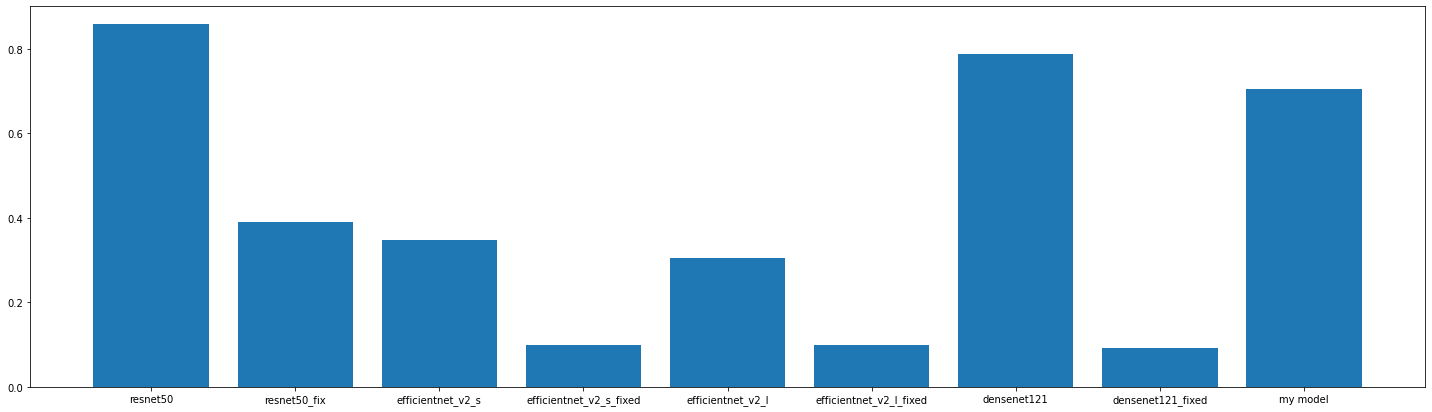

In [75]:
fig, ax = plt.subplots(1, 1, figsize = (25, 7))
ax.bar(names, scores)

Лучшую точность показала модель resnet50, обученная полностью. Точность на тестовой выборке составила примерно 86%.
Модели efficientnet_v2_s и efficientnet_v2_l в данной работе полностью не переобучались, переобучались только последний 20 слоев. Это сделано для того, чтобы обучение занимало разумное время, так как модели очень "большие". Возможно, при полном обучении этих моделей, они могли показать лучшую точность.